In [ ]:
#Import the essential libraries
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.models.vgg import vgg16
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report

In [ ]:
# Use GPU
use_cuda = torch.cuda.is_available()

# Import dataset and apply data agumentation
img_to_tensor = transforms.ToTensor()
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])                                
                  
data_dir = '/content/drive/My Drive/chest_xray/'

train_data = datasets.ImageFolder(data_dir + 'train', transform_train)
test_data = datasets.ImageFolder(data_dir + 'test', transform_test)
valid_data = datasets.ImageFolder(data_dir + 'val', transform_train)

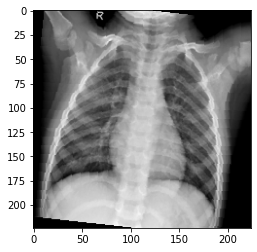

In [ ]:
plt.imshow(train_data[10][0].permute(1, 2, 0))

In [ ]:
# Rearrage the validation data and train data
random_seed = 0
torch.manual_seed(random_seed);
dataset = ConcatDataset([train_data, valid_data])
# New split of 
train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=random_seed)

In [ ]:
# Build dataloader in torch
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Use gc to clear GPU memory
import gc
EPOCH = 10

'''
Build a cnn model and train it by train data.
Select the best one using

net: string net type
'''
def cnn_classfication(net):
  if net == 'resnet18':
    net_xray = torchvision.models.resnet18()
    num_features = net_xray.fc.in_features
    net_xray.fc = nn.Linear(num_features, 2)
  elif net == 'resnet34':
    net_xray = torchvision.models.resnet34()
    num_features = net_xray.fc.in_features
    net_xray.fc = nn.Linear(num_features, 2)
  elif net == 'vgg11':
    net_xray = torchvision.models.vgg.vgg11()
    net_xray.classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=2, bias=True)) 
  elif net == 'vgg16':
    net_xray = torchvision.models.vgg.vgg16()
    net_xray.classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=2, bias=True))
  # Use gpu
  if use_cuda:
    net_xray.cuda()
  # applying weighted cross-entropy loss
  weight_tensor = torch.Tensor([3499/(1209+3499), 1209/(1209+3499)]).cuda()
  Loss = nn.CrossEntropyLoss(weight = weight_tensor)
  LR = 0.0001
  min_loss = 100000.0
  optimizer = optim.Adam(net_xray.parameters(), lr=LR)
  train_losses = []
  val_losses = []
  torch.cuda.empty_cache()
  # Train the model
  for epoch in range(EPOCH):
    gp = 0
    gn = 0
    totaltrain = 0
    correcttrain = 0
    totalval = 0
    correctval = 0
    print('Epoch: ',epoch, ' starts')
    running_loss = 0
    val_loss = 0
    for i, (images, labels) in enumerate(train_loader):
      gc.collect()
      torch.cuda.empty_cache()
      #print(i)
      # for images, labels in trainLoader:
      images = Variable(images)
      labels = Variable(labels)
      gp += (labels == 1).sum()
      gn += (labels == 0).sum()
      if use_cuda:
        #print('GPU Working')
        images = images.cuda()
        labels = labels.cuda()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = net_xray(images)
        _, predicted = torch.max(outputs.data, 1)
        loss = Loss(outputs, labels)
        running_loss += loss.item() * images.size(0)
        totaltrain += labels.size(0)
        correcttrain += (predicted == labels).sum()
        loss.backward()
        optimizer.step()

    print('Training Accuracy of the model on the train images: %f %%' % (100 * correcttrain / totaltrain))
    net_xray.eval()
    correctval = 0
    totalval = 0
    flag = 0
    for images, labels in valid_loader:
      if use_cuda:
          images, labels = images.cuda(), labels.cuda()  
      output = net_xray(images)
      _, predicted = torch.max(output.data, 1)
      loss = Loss(output, labels)
      totalval += labels.size(0)
      correctval += (predicted == labels).sum()
      
      val_loss += loss.item() * images.size(0)
    if val_loss < min_loss:
      torch.save(model,model_dir)
      print('Model updates')
      min_loss = val_loss
      flag = 1
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(valid_loader.dataset)
    print('Validation Accuracy of the model on the val images: %f %%' % (100 * correctval / totalval))
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)


    if flag == 1:
      for images, labels in test_loader:
        images = images.cuda()
        target = target.cuda()
        outputs = net_xray(images)

        _, predicted = torch.max(outputs.data, dim=1)
        all_preds = torch.cat((all_preds, outputs.cpu()),dim=0)
        targets = torch.cat((targets, target.cpu()),dim=0)
      print(classification_report(np.array(targets), all_preds.argmax(dim=1),digits = 3))

    net_xray.train()
